In [1]:
import matplotlib.pyplot as plt
import random

from pyClarion import (Family, Atoms, Atom, Agent, Input, Choice, IDN, Train, TDError)

In [3]:
class IO(Atoms):
    input: Atom
    output: Atom

class Greeting(Atoms):
    nil: Atom
    hello: Atom
    goodbye: Atom

class Reward(Atoms):
    correct: Atom

class HelloWorldFamily(Family):
    io: IO
    reward: Reward
    greeting: Greeting

In [4]:
from IPython.display import display, clear_output
import logging
import sys

# logger = logging.getLogger("pyClarion.system")
# logger.setLevel(logging.DEBUG)
# logger.addHandler(logging.StreamHandler(sys.stdout))

In [7]:
p = Family()
h = Family()
d = HelloWorldFamily()
io = d.io
greeting = d.greeting
reward = d.reward
with Agent("agent", p=p, d=d, h=h) as agent:
    ipt = Input("ipt", (io.input, greeting))
    with Choice("choice", p, (io.output, greeting)) as choice:
        net = ipt >> IDN("net", # An 'implicit decision network'
            p=p, # Network parameters rperesented by keys of this family          
            h=h, # Hidden nodes represented by keys of this family
            r=reward, # Rewards represented by keys of this sort
            s1=(io.input, greeting), # Keyspace for network inputs
            s2=(io.output, greeting), # Keyspace for network outputs
            layers=(), # Sequence of layer sizes (empty means single layer mlp)
            train=Train.WEIGHTS,
            gamma=.3, # Discount factor
            lr=1e-2, # Learning rate
        )
        choice.input = net.olayer.main

In [9]:
rewards = [
    {
        "stimulus": + io.input ** greeting.hello, 
        "reward": {
            ~io.output * ~greeting.hello:   +1.0, 
            ~io.output * ~greeting.goodbye: -1.0,
            ~io.output * ~greeting.nil:     -0.5
        }
    },
    {
        "stimulus": + io.input ** greeting.goodbye, 
        "reward": {
            ~io.output * ~greeting.hello:   -1.0, 
            ~io.output * ~greeting.goodbye: +1.0,
            ~io.output * ~greeting.nil:     -0.5
        }
    },
]

In [15]:
results = []
reward_vals = []
qvals = []
STOP = 1000
N = 100
err, i = float("inf"), 1
while i <= STOP:
    random.shuffle(rewards)
    data = rewards[0]
    ipt.send(data["stimulus"])
    while agent.system.queue:
        event = agent.system.advance()
        if event.source == net.error.update:
            results.append(net.error.main[0].pow(x=2.0))
        if event.source == net.olayer.forward:
            choice.select()
        if event.source == choice.select:
            action = choice.poll()[~io.output * ~greeting]
            r = data["reward"][action]
            net.error.send({reward.correct: r})
            reward_vals.append(r)
            qvals.append(choice.input[0].max().c)
    if i % N == 0:
        err = net.error.main.new({}).sum(*results).sum().scale(x=1 / N).c
        print(f"{i} {round(err, 3)}")
        results.clear()
    i += 1

100 0.0
200 0.0
300 0.0
400 0.0
500 0.0
600 0.0
700 0.0
800 0.0
900 0.0
1000 0.0


In [16]:
window = N
cumulqvals = []
cumulative = []
for i in range(0, STOP - window):
    cumulqvals.append(sum(qvals[i:i + window])/window)
    cumulative.append(sum(reward_vals[i:i + window])/window)


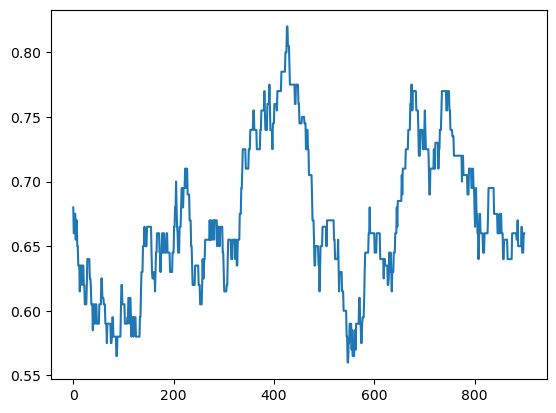

In [17]:
plt.plot(cumulative)
plt.show()

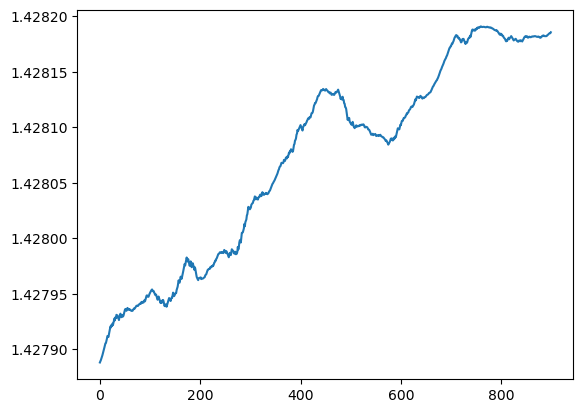

In [18]:
plt.plot(cumulqvals)
plt.show()